# Predicting type of urban crime

## Python, Kaggle, and SF OpenData

---

Hana Lee

14 January 2016

ChiPy Monthly Meeting

## Python's data stack

* `numpy` and `pandas` for data manipulation and cleaning
* `matplotlib` and `seaborn` for exploratory data analysis and data visualization
* `scikit-learn` for machine learning algorithms

## What is Kaggle?

* Gamification of machine learning
* Primarily supervised learning problems submitted by businesses, researchers, and government

## San Francisco crime classification

* SFPD Crime Incident Reporting system data from 1/1/2003 to 5/13/2015
* Made available via SF OpenData 

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
sns.set_context(context="talk")

In [3]:
sfcrimes = pd.read_csv("train.csv")
sfcrimes["Category"] = sfcrimes["Category"].astype("category")

from sklearn.preprocessing import LabelEncoder
cat_codes = LabelEncoder()
cat_codes.fit(sfcrimes["Category"].cat.categories)

sfcrimes["CatCodes"] = cat_codes.transform(sfcrimes["Category"])

## Looking at the data

In [4]:
sfcrimes.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CatCodes
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,37
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,21
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,21


* Not many variables
* Test data set does not have Description or Resolution

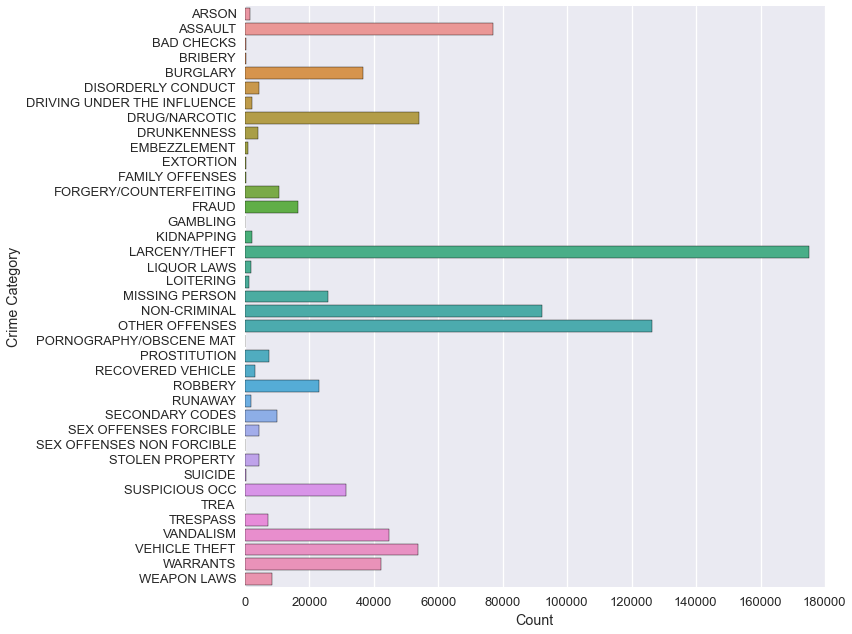

In [39]:
plt.figure(figsize = (8*1.3, 8*1.3))
sns.countplot(y = "Category", data = sfcrimes)
sns.axlabel("Count", "Crime Category")

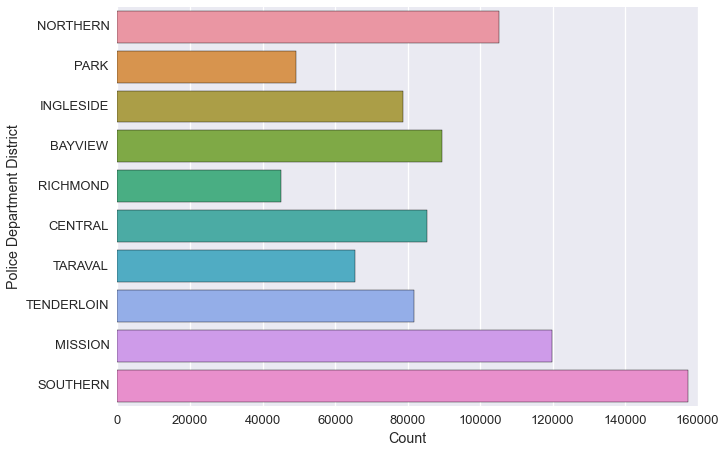

In [20]:
sns.countplot(y="PdDistrict", data=sfcrimes)
sns.axlabel("Count", "Police Department District")

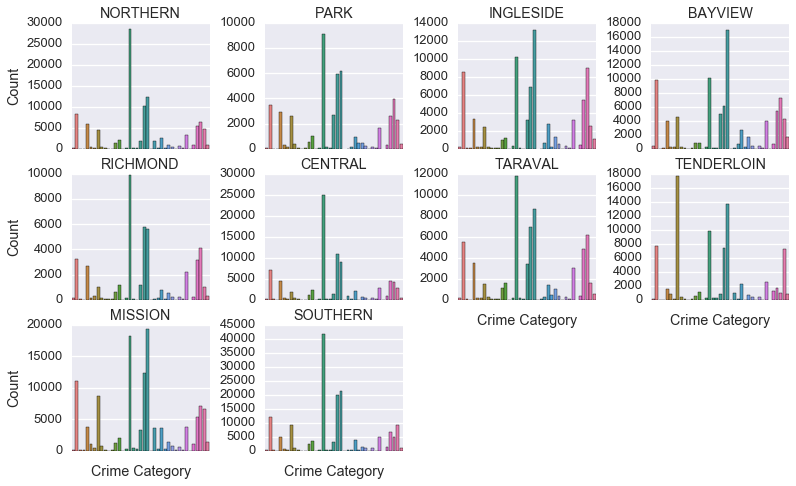

In [22]:
g = sns.FacetGrid(col = "PdDistrict", data = sfcrimes, col_wrap = 4, 
                  size = 1.8*1.3, aspect = 1.3, sharey = False)
(g.map(sns.countplot, "Category", palette = "husl")
  .set_axis_labels("Crime Category", "Count")
  .set_xticklabels([])
  .set_titles("{col_name}")
  .fig.subplots_adjust(hspace = 0.2, wspace = 0.4))

## A preliminary model

* Let's just look at `PdDistrict` for now
* Logistic regression to build a classifier
* Log-loss metric on 5-fold cross-validation to evaluate model performance

In [5]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

kf = StratifiedKFold(sfcrimes["CatCodes"], 
                     n_folds=5, 
                     shuffle=True, 
                     random_state=333)

def log_loss_kfold(alg, train_features, train_target,
                   test_features, test_target):
    train_fit = alg.fit(train_features, train_target)
    test_pred = train_fit.predict_proba(test_features)
    return log_loss(test_target, test_pred)

In [6]:
features = pd.get_dummies(sfcrimes["PdDistrict"], 
                          prefix="Pd")
features.head(3)

,Pd_BAYVIEW,Pd_CENTRAL,Pd_INGLESIDE,Pd_MISSION,Pd_NORTHERN,Pd_PARK,Pd_RICHMOND,Pd_SOUTHERN,Pd_TARAVAL,Pd_TENDERLOIN
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0


In [7]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()

scores = [log_loss_kfold(logr,
                         features.iloc[train_idx],
                         sfcrimes["CatCodes"].iloc[train_idx],
                         features.iloc[test_idx],
                         sfcrimes["CatCodes"].iloc[test_idx])
          for train_idx, test_idx in kf]
sum(scores)/len(scores)

2.6154519949292041

## How did it do against the test set?

* Log-loss score = 2.61626
* Top score = 2.06702
* Police district by itself still does surprisingly well

## Higher-resolution geographical data

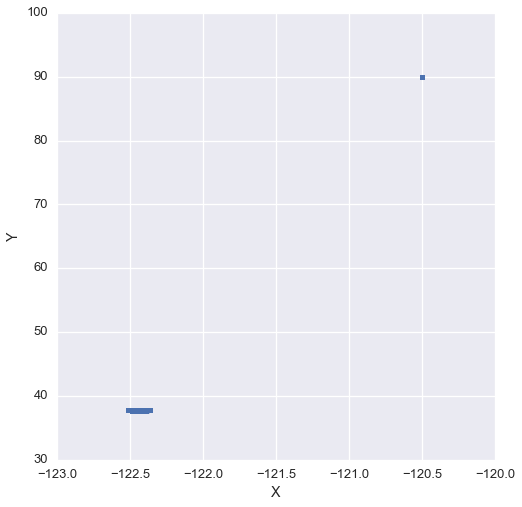

In [23]:
g = sns.PairGrid(data = sfcrimes, x_vars = ['X'], y_vars = ['Y'], size = 5.5*1.3)
g = g.map(plt.scatter)

### Impute values of outliers

* `X` and `Y` represent longitude and latitude
* Outliers probably due to incorrect data entry
* Use mean longitude and latitude from police district

In [25]:
pd_districts = sfcrimes.groupby("PdDistrict")
pd_means = pd_districts.agg({'X': np.mean,
                             'Y': np.mean})

outliers = (sfcrimes['X'] > -122) | (sfcrimes['Y'] > 38)
imputed_values = pd.DataFrame({idx: pd_means.loc[row['PdDistrict']]
                               for idx, row in sfcrimes[outliers].iterrows()})
sfcrimes.loc[outliers, ('X', 'Y')] = imputed_values.transpose()

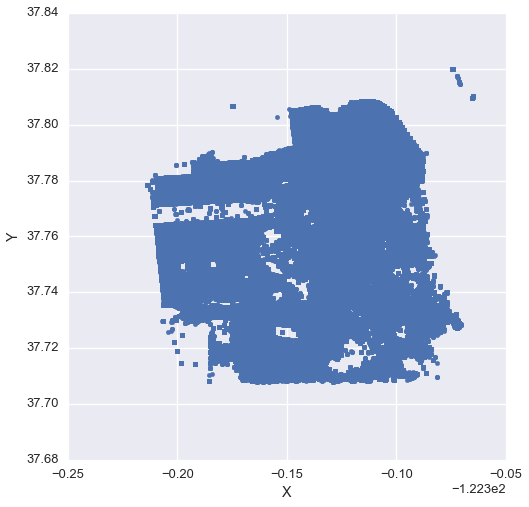

In [29]:
g = sns.PairGrid(data = sfcrimes, x_vars = ['X'], y_vars = ['Y'], size = 5.5*1.3)
g = g.map(plt.scatter)

### Cluster into neighborhoods

* Tried using as continuous variables but model performed better when categorical
* Used _k_-means (unsupervised learning!) to determine "neighborhoods"
* Looked at inertia (sum of distances from cluster centroids) to pick number of clusters
* _k_ = 150

In [27]:
from sklearn.cluster import KMeans

k150 = KMeans(n_clusters = 150,
              max_iter = 100,
              random_state = 333).fit(sfcrimes[['X', 'Y']])
sfcrimes["Neighborhood"] = k150.predict(sfcrimes[['X', 'Y']])

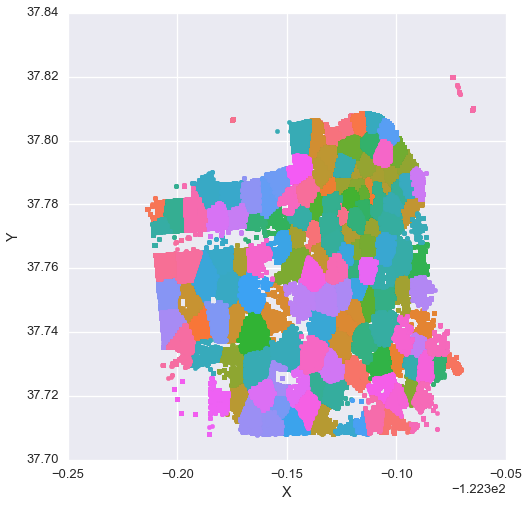

In [42]:
g = sns.PairGrid(data = sfcrimes, x_vars = ['X'], y_vars = ['Y'],
                 hue = "Neighborhood", palette = "husl", size = 5.5*1.3)
g = g.map(plt.scatter)

## Datetime data

* Convert `Dates` to Python datetime objects
* Extract year and month
* Group hours into 6-hour intervals as "time of day" 

In [30]:
timestamps = pd.to_datetime(sfcrimes["Dates"])
timestamps.index = pd.DatetimeIndex(timestamps)

In [31]:
sfcrimes["Year"] = timestamps.index.year
sfcrimes["Month"] = timestamps.index.month

In [32]:
def time_of_day(hour):
    if hour >= 1 and hour < 7:
        return "night"
    elif hour >=7 and hour < 12:
        return "morning"
    elif hour >= 12 and hour < 18:
        return "afternoon"
    else:
        return "evening"

sfcrimes["TimeOfDay"] = pd.Series([time_of_day(hour) 
                                   for hour in timestamps.index.hour])

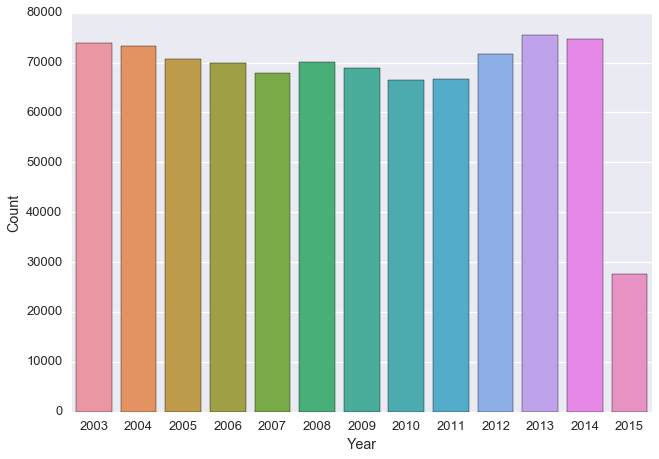

In [33]:
sns.countplot(x = "Year",
              data = sfcrimes,
              order = range(2003, 2016))
sns.axlabel("Year", "Count")

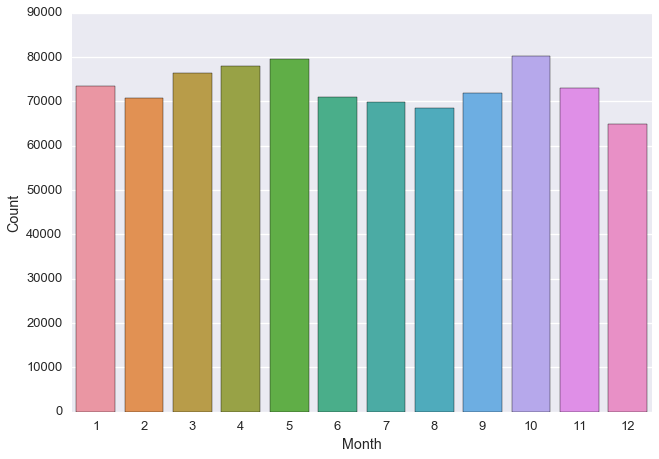

In [34]:
sns.countplot(x = "Month",
              data = sfcrimes,
              order = range(1, 13))
sns.axlabel("Month", "Count")

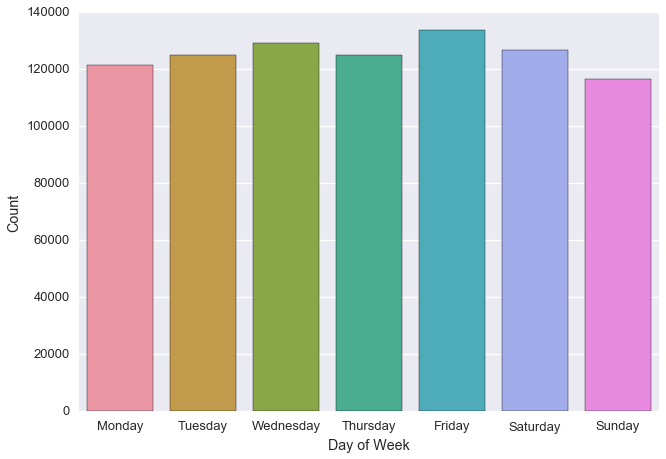

In [35]:
DAYS = ["Mon", "Tues", "Wednes", "Thurs", "Fri", "Satur", "Sun"]

sns.countplot(x = "DayOfWeek",
              data = sfcrimes,
              order = [x + "day" for x in DAYS])
sns.axlabel("Day of Week", "Count")

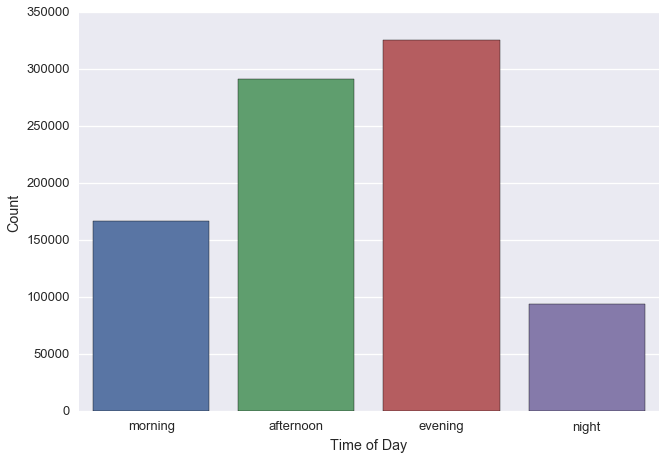

In [36]:
sns.countplot(x = "TimeOfDay",
              data = sfcrimes,
              order = ["morning", "afternoon", "evening", "night"])
sns.axlabel("Time of Day", "Count")

## A more complicated model

* Adding higher-resolution geographical and datetime data
* Treating as categorical variables
* Logistic regression to fit the training set data

In [37]:
features = pd.concat([pd.get_dummies(sfcrimes["Year"],
                                     prefix = "Y"),
                      pd.get_dummies(sfcrimes["Month"],
                                     prefix = "M"),
                      pd.get_dummies(sfcrimes["DayOfWeek"]),
                      pd.get_dummies(sfcrimes["TimeOfDay"]),
                      pd.get_dummies(sfcrimes["PdDistrict"],
                                     prefix = "Pd"),
                      pd.get_dummies(sfcrimes["Neighborhood"],
                                     prefix = "N")],
                     axis = 1)
features.head(3)

,Y_2003,Y_2004,Y_2005,Y_2006,Y_2007,Y_2008,Y_2009,Y_2010,Y_2011,Y_2012,...,N_140,N_141,N_142,N_143,N_144,N_145,N_146,N_147,N_148,N_149
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
scores = [log_loss_kfold(logr,
                         features.iloc[train_idx],
                         sfcrimes["CatCodes"].iloc[train_idx],
                         features.iloc[test_idx],
                         sfcrimes["CatCodes"].iloc[test_idx])
          for train_idx, test_idx in kf]
sum(scores)/len(scores)

2.4945534888938781

## How did it do against the test set?

* Score = 2.54026
* Top score = 2.05079
* Moved up 306 positions on the leaderboard

## Which features are useful?

* Assess feature importance using classification trees
* Fit random forests model

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 10,
                            min_samples_leaf = 5,
                            max_depth = 40,
                            random_state = 333)

rf_model = rf.fit(features, sfcrimes["CatCodes"])

In [39]:
importance = pd.DataFrame({"Features": features.columns,
                           "Importances": rf_model.feature_importances_})
importance = importance.sort_values("Importances", ascending = False)

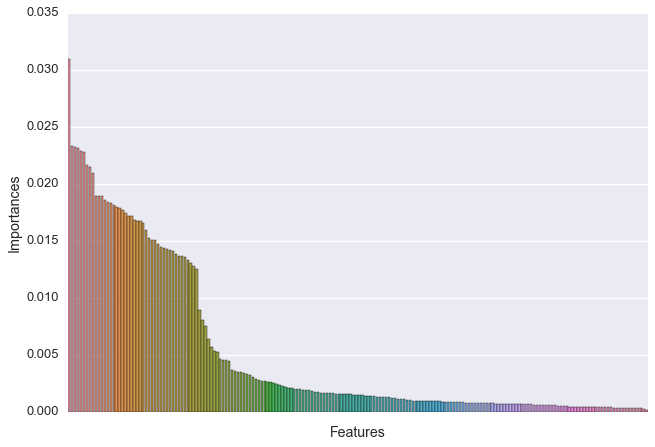

In [40]:
g = sns.barplot(data = importance, x = "Features", y = "Importances")
g.set_xticklabels([])
sns.axlabel("Features", "Importances")

In [41]:
importance[importance["Importances"] > 0.02]

,Features,Importances
45,Pd_TENDERLOIN,0.030904
31,Wednesday,0.023323
25,Friday,0.023185
30,Tuesday,0.023098
26,Monday,0.022834
29,Thursday,0.022794
28,Sunday,0.021667
27,Saturday,0.021442
33,evening,0.020961


## Improving the classifier

* Combine models generated using different methods
* Take mean of predictions from logistic regression and random forests

In [43]:
logr_model = logr.fit(features, sfcrimes["CatCodes"])

In [49]:
def combine_models(model_list, test_data):
    predict = np.array([model.predict_proba(test_data)
                            for model in model_list])
    mean_predict = pd.DataFrame(predict.mean(axis = 0))
    normalize = mean_predict.div(mean_predict.sum(axis = 1),
                                 axis = 0)
    return normalize

In [45]:
kaggle_test = pd.read_csv("test.csv")

kaggle_outliers = (kaggle_test['X'] > -122) | (kaggle_test['Y'] > 38)
kaggle_imputed = pd.DataFrame({idx: pd_means.loc[row['PdDistrict']]
                               for idx, row in kaggle_test[kaggle_outliers].iterrows()})
kaggle_test.loc[kaggle_outliers, ('X', 'Y')] = kaggle_imputed.transpose()

kaggle_test["Neighborhood"] = k150.predict(kaggle_test[['X', 'Y']])

kaggle_timestamps = pd.to_datetime(kaggle_test["Dates"])
kaggle_timestamps.index = pd.DatetimeIndex(kaggle_timestamps)

kaggle_test["Year"] = kaggle_timestamps.index.year
kaggle_test["Month"] = kaggle_timestamps.index.month
kaggle_test["TimeOfDay"] = pd.Series([time_of_day(hour) 
                                      for hour in kaggle_timestamps.index.hour])

kaggle_features = pd.concat([pd.get_dummies(kaggle_test["Year"], 
                                            prefix = "Y"),
                             pd.get_dummies(kaggle_test["Month"], 
                                            prefix = "M"),
                             pd.get_dummies(kaggle_test["DayOfWeek"]),
                             pd.get_dummies(kaggle_test["TimeOfDay"],
                                            prefix = "Time"),
                             pd.get_dummies(kaggle_test["PdDistrict"],
                                            prefix = "Pd"),
                             pd.get_dummies(kaggle_test["Neighborhood"])],
                            axis = 1)
kaggle_features.head(3)

,Y_2003,Y_2004,Y_2005,Y_2006,Y_2007,Y_2008,Y_2009,Y_2010,Y_2011,Y_2012,...,140,141,142,143,144,145,146,147,148,149
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
kaggle_pred = combine_models([logr_model, rf_model], kaggle_features)
colnames = cat_codes.inverse_transform(logr_model.classes_)
kaggle_pred.columns = colnames
kaggle_pred.to_csv(path_or_buf="/Users/hanalee/sfcrimes/model7.csv",
                   index_label="Id")

## How did it do against the test set?

* Log-loss score = 2.49766
* Top score = 2.05079
* Moved up 58 positions on leaderboard

## Endnotes

* Github: http://github.com/hnlee/sfcrimes
* Slides: http://hnlee.github.io/sfcrimes/
* Thanks to Eric Meschke and Alex Flyax for mentorship
* Looking for a job outside academia!
     * Email: hanalee07@gmail.com
     * Resume: http://hanalee.info/static/pdfs/resume.pdf
     * LinkedIn: https://www.linkedin.com/in/hanalee07